In [330]:
import os
import inspect
import pandas as pd
from PIL import Image

import prefect
import datetime
from prefect.tasks.shell import ShellTask
from prefect import Flow,task, Parameter
from prefect.schedules import IntervalSchedule
from prefect.engine.signals import SKIP


In [331]:
@task
def filepath(Xfolder,SFolder,Folder,File):

    cwd = os.path.dirname(os.path.dirname(os.path.abspath(inspect.stack()[0][1])))
    print(cwd)
    read_file = os.path.join(cwd,Xfolder,SFolder,Folder,File)
    return read_file

In [332]:
@task(skip_on_upstream_skip=False)
def git_command(url, target):
    """
    The git command we wish to execute
    """
    return "! git clone {url} {target}".format(target=target, url=url)




In [333]:
@task
def rm_cmd(fpath):
    """
    The git command we wish to execute
    """
    print("------------------------------------------------- rm ${fpath}/*".format(fpath=fpath))
    if not os.listdir(fpath):
         raise SKIP
    else:    
        return "rm -r {fpath}".format(fpath=fpath)
    

In [334]:
# ShellTask is a task from the Task library which will execute a given command in a subprocess
# and fail if the command returns a non-zero exit code


git_clone = ShellTask(name="cloning", max_retries=2, retry_delay=datetime.timedelta(seconds=15),skip_on_upstream_skip=False)
remove_files = ShellTask(name="clearing_targer_folder",max_retries=2, retry_delay=datetime.timedelta(seconds=5))

In [335]:
@task(max_retries=2, retry_delay=datetime.timedelta(seconds=5))
def filter_data(meta_path,img_folder):

    raw_data=pd.read_csv(meta_path)
    
    
    """
    Filtering data for PA,AP,AP Supine
    """      
    
    filter_list=['PA','AP','AP Supine']
    df=raw_data[raw_data['view'].isin(filter_list)]
    print("Len of raw data {a}, len after filtering for views {b}".format(a=len(raw_data), b=len(df)))    #to be del
    
    """
    Filtering data for PA,AP,AP Supine
    """  
        
    imgs_path=[file for file in os.listdir(img_folder)]
    df=df[df['filename'].isin(imgs_path)] 
    print("len afte filtering for filenames {a}".format(a=len(df)) )    #to be del
    
    """
    Filtering based on size of xrays
    """
    
    for item in df['filename']:
        df.loc[df['filename'] == item, 'height'],df.loc[df['filename'] == item, 'width']=Image.open(os.path.join(img_folder,item)).size
    df_included=df[(df['height']>1023) & (df['width']>1023)] 
    df_excluded=df[~df['filename'].isin(df_included['filename'])]
    
    
    df_included['fullfilepath']= str(img_folder) + "/"  + df['filename'].astype(str)
    df_excluded['fullfilepath']= str(img_folder) + "/"  + df['filename'].astype(str)
    
    df_excluded=df_excluded[['filename','height','width','fullfilepath']]
    
    return [df_included,df_excluded, df_included['fullfilepath'],df_excluded['fullfilepath']]


In [336]:
@task
def load(metadata,result_location):

    metadata[0].to_csv("{result_location}/images.csv_metadata".format(result_location=result_location))
    metadata[1].to_csv("{result_location}/excluded_images_metadata.csv".format(result_location=result_location))
    

In [345]:
@task
def move_imgs(input_path,folder_name,result_location,images_list):
    
    
    print('images_list')
    images_list.to_csv("{res}/{fname}_path.txt".format(res=result_location,fname=folder_name),header=False,index=False)
    
    
    print("xargs mv -t {res}/{fn} < {res}/{fn}_path.txt".format(res=result_location,in_p=input_path,fn=folder_name))
    return "xargs mv -t {res}/{fn} < {res}/{fn}_path.txt".format(res=result_location,in_p=input_path,fn=folder_name)

In [346]:
move=ShellTask(name="moving images", max_retries=2, retry_delay=datetime.timedelta(seconds=15))

In [347]:
with Flow ('ETL') as flow:
    
    #Input Parameters
    target_location=filepath("","","","data")
    git_url = Parameter("git_url",
                     default="https://github.com/ieee8023/covid-chestxray-dataset")
    
    metadata_path=filepath("","","data","metadata.csv")
    images_folder=filepath("","","data","images")
    
    results_path=filepath("","","","results")
    
    ### Extraction
    
    #clearing folders
    clear_target_location_command=rm_cmd(target_location)
    clearing_target_location=remove_files(command=clear_target_location_command)
    
    #Cloning git repo
    git_command = git_command(git_url,target_location)
    raw_data = git_clone(command=git_command,upstream_tasks=[clearing_target_location])
    
    ### Transform
    
    metadata=filter_data(metadata_path,images_folder,upstream_tasks=[raw_data])
    
    
    ### Load
    
    load(metadata,results_path)
    included_images_cmd=move_imgs(images_folder,'images',results_path,metadata[2])
    move(command=included_images_cmd)
    excluded_images_cmd=move_imgs(images_folder,'excluded_images',results_path,metadata[3])
    move(command=excluded_images_cmd)
    

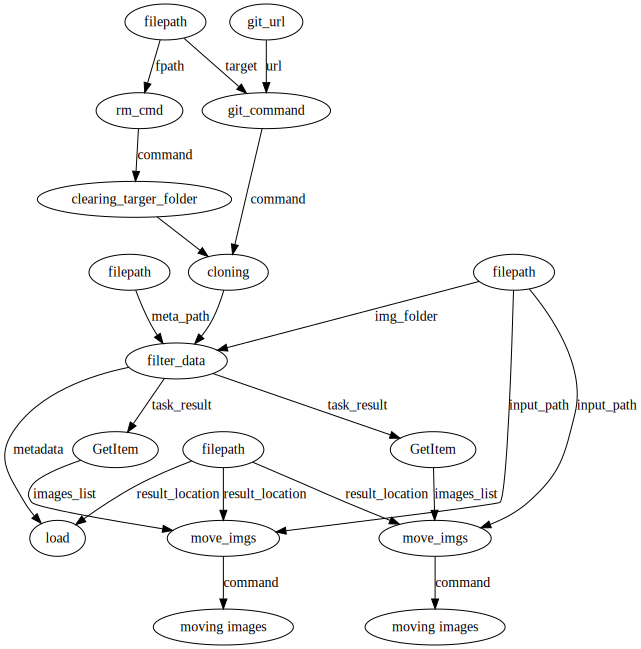

In [348]:
flow.visualize()

In [ ]:
flow.run()

[2020-09-09 23:40:06] INFO - prefect.FlowRunner | Beginning Flow run for 'ETL'
[2020-09-09 23:40:06] INFO - prefect.TaskRunner | Task 'filepath': Starting task run...
/home/ubuntu/data_pipeline
[2020-09-09 23:40:06] INFO - prefect.TaskRunner | Task 'filepath': finished task run for task with final state: 'Success'
[2020-09-09 23:40:06] INFO - prefect.TaskRunner | Task 'filepath': Starting task run...
/home/ubuntu/data_pipeline
[2020-09-09 23:40:06] INFO - prefect.TaskRunner | Task 'filepath': finished task run for task with final state: 'Success'
[2020-09-09 23:40:06] INFO - prefect.TaskRunner | Task 'filepath': Starting task run...
/home/ubuntu/data_pipeline
[2020-09-09 23:40:06] INFO - prefect.TaskRunner | Task 'filepath': finished task run for task with final state: 'Success'
[2020-09-09 23:40:06] INFO - prefect.TaskRunner | Task 'filepath': Starting task run...
/home/ubuntu/data_pipeline
[2020-09-09 23:40:06] INFO - prefect.TaskRunner | Task 'filepath': finished task run for task w